# Finding Relative Value Pairs Trades using Machine Learning

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from statsmodels.tsa.stattools import coint

from scipy import stats

from quantopian.pipeline.data import morningstar
from quantopian.pipeline.filters.morningstar import Q500US, Q1500US, Q3000US
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

##  Step 1: Define Stock Universe
We start by specifying our universe for trade opportunities to a liquid single stock universe of 1500 stocks for a given date

In [3]:
trade_date = "2020-01-06"

universe = Q1500US()

## Step 2: Retrieve Stock Classification Data

We use include Market Capitalization, Industry, and Credit Risk from MorningStar to help identify
stocks that should be highly correlated.  Remove any stocks with missing data or companies that
participate in multiple industries.

In [4]:

pipe = Pipeline(
    columns= {
        'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),
        'Industry': morningstar.asset_classification.morningstar_industry_group_code.latest,
        'Financial Health': morningstar.asset_classification.financial_health_grade.latest
    },
    screen=universe
)

In [6]:
res = run_pipeline(pipe, trade_date, trade_date)
res.index = res.index.droplevel(0)  # drop the date header row

In [7]:
print res.shape
res.head()

(1500, 3)


,Financial Health,Industry,Market Cap
Equity(2 [ARNC]),B,31070,4
Equity(24 [AAPL]),A,31120,4
Equity(53 [ABMD]),B,20650,4
Equity(62 [ABT]),A,20650,4
Equity(67 [ADSK]),B,31110,4


In [8]:
# remove stocks in Industry "Conglomerates"
res = res[res['Industry']!=31055]
print res.shape

(1500, 3)


In [9]:
# remove stocks without a Financial Health grade
res = res[res['Financial Health']!= None]
print res.shape

(1498, 3)


In [10]:
# replace the categorical data with numerical scores 
res['Financial Health'] = res['Financial Health'].astype('object')
health_dict = {u'A': 0.1,
               u'B': 0.3,
               u'C': 0.7,
               u'D': 0.9,
               u'F': 1.0}
res = res.replace({'Financial Health': health_dict})

In [11]:
res.describe()

,Financial Health,Industry,Market Cap
count,1498.000000,1498.000000,1498.000000
mean,0.454940,20824.042056,3.463284
std,0.273438,9098.953897,0.622706
min,0.100000,10110.000000,2.000000
25%,0.300000,10340.000000,3.000000
50%,0.300000,20630.000000,4.000000
75%,0.700000,31040.000000,4.000000
max,1.000000,31130.000000,4.000000


## Step 3: Retrieve Price History

Retrieve closing prices for each stock for the past 2 years and calculate daily percent returns.

In [12]:
pricing = get_pricing(
    symbols=res.index,
    fields='close_price',
    start_date=pd.Timestamp(trade_date) - pd.DateOffset(months=24),
    end_date=pd.Timestamp(trade_date)
)

In [13]:
pricing.shape

(502, 1498)

In [15]:
returns = pricing.pct_change() # Calculate daily % return for each stock

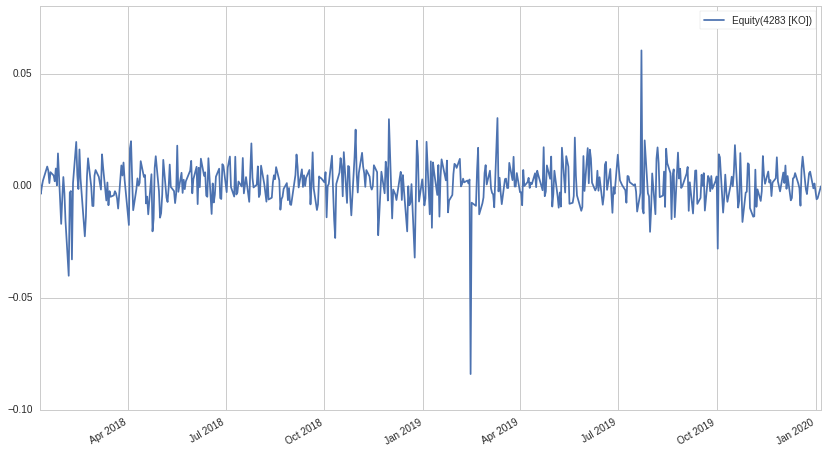

In [53]:
# Plot the daily % returns of a sample stock 
returns[symbols(['KO'])].plot();

In [17]:
# Remove any stocks with incomplete history for the analysis period
returns = returns.iloc[1:,:].dropna(axis=1)

In [18]:
print returns.shape

(501, 1364)


## Step 4: Identify Clusters of Related Stocks

Use PCA (Principle Component Analysis) to reduce the dimensionality of returns and extract common factors.
We then use DBSCAN an unsupervised clustering algorithm in sklearn to and use DBSCAN to identify clusters of cointegrated securities.

In [21]:
# Perform Principle Component Analysis on returns
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(returns)

PCA(copy=True, n_components=50, whiten=False)

In [22]:
pca.components_.T.shape

(1364, 50)

In [23]:
# Add Market Cap and Financial Health data 

X = np.hstack(
    (pca.components_.T,
     res['Market Cap'][returns.columns].values[:, np.newaxis],
     res['Financial Health'][returns.columns].values[:, np.newaxis])
)

print X.shape

(1364, 52)


In [24]:
X = preprocessing.StandardScaler().fit_transform(X)
print X.shape

(1364, 52)


In [25]:
# Find Clusters using DBSCAN

clf = DBSCAN(eps=1.9, min_samples=3)
print clf

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print "\nClusters discovered: %d" % n_clusters_

clustered = clf.labels_

DBSCAN(algorithm='auto', eps=1.9, leaf_size=30, metric='euclidean',
    min_samples=3, p=None, random_state=None)

Clusters discovered: 16


In [26]:
ticker_count = len(returns.columns)
print "Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2)

Total pairs possible in universe: 929566 


In [27]:
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [28]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print "Clusters formed: %d" % len(ticker_count_reduced)
print "Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum()

Clusters formed: 16
Pairs to evaluate: 3260


In [29]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

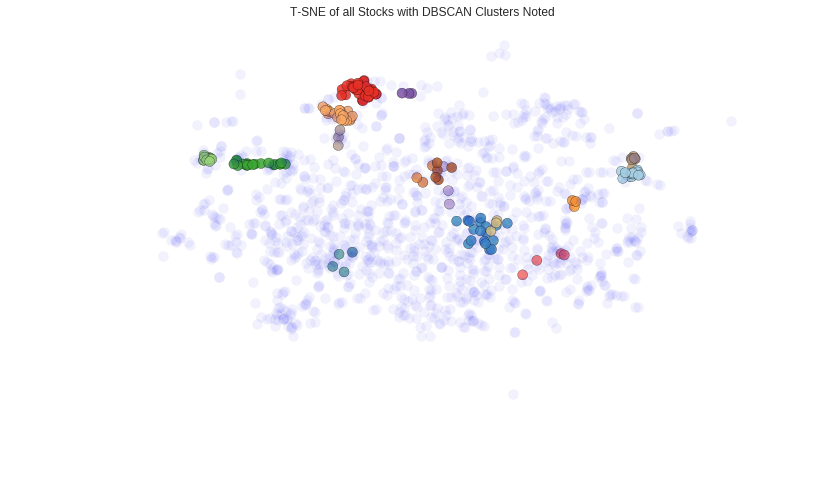

In [30]:
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted');

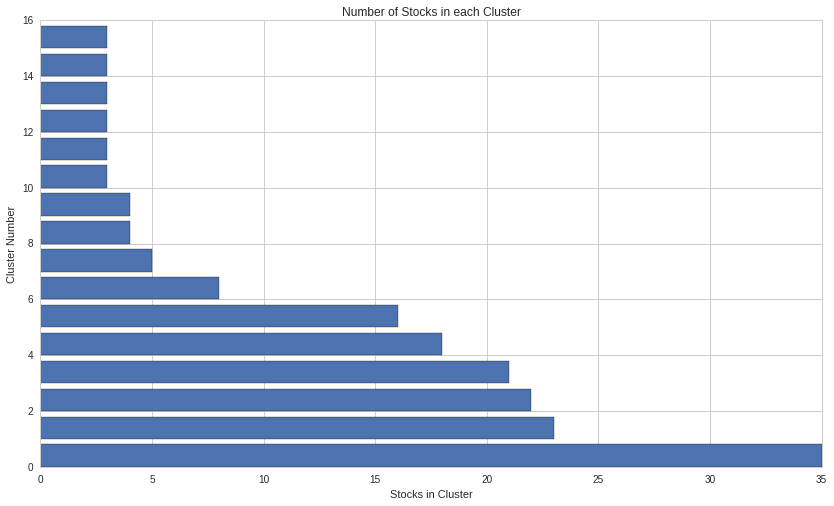

In [31]:
plt.barh(
    xrange(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Number of Stocks in each Cluster')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

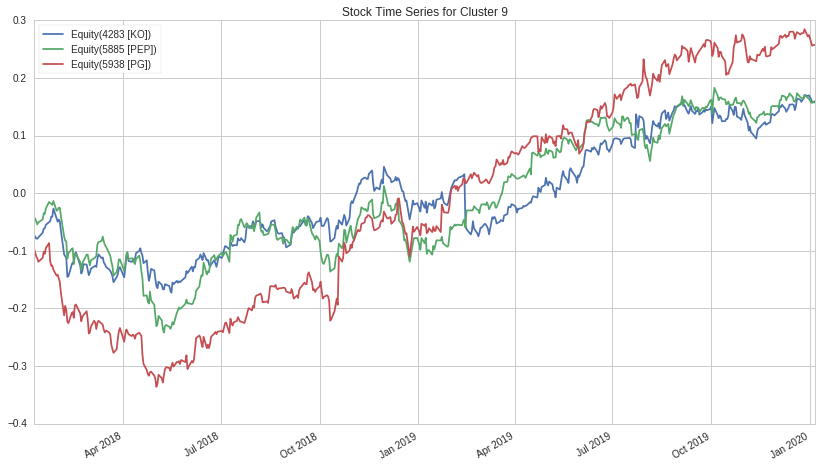

In [32]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 1)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(pricing[tickers].mean())
    data = np.log(pricing[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)

In [33]:
which_cluster = clustered_series.loc[symbols('KO')]
clustered_series[clustered_series == which_cluster]

Equity(4283 [KO])     9
Equity(5885 [PEP])    9
Equity(5938 [PG])     9
dtype: int64

In [35]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [36]:

cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        pricing[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [37]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [49]:
print "From %d possible pairs" % (ticker_count*(ticker_count-1)/2) 
print "%d pair trades were found" % len(pairs)

pairs

From 929566 possible pairs
143 pair trades were found


[(Equity(161 [AEP]), Equity(21964 [XEL])),
 (Equity(161 [AEP]), Equity(36098 [AWK])),
 (Equity(612 [ATO]), Equity(1665 [CMS])),
 (Equity(612 [ATO]), Equity(2434 [ED])),
 (Equity(612 [ATO]), Equity(8140 [WEC])),
 (Equity(612 [ATO]), Equity(21964 [XEL])),
 (Equity(2330 [DTE]), Equity(24783 [AEE])),
 (Equity(2434 [ED]), Equity(8140 [WEC])),
 (Equity(2434 [ED]), Equity(21964 [XEL])),
 (Equity(2434 [ED]), Equity(36098 [AWK])),
 (Equity(2637 [ETR]), Equity(2968 [NEE])),
 (Equity(2637 [ETR]), Equity(7011 [SO])),
 (Equity(2968 [NEE]), Equity(6193 [WTR])),
 (Equity(2968 [NEE]), Equity(7011 [SO])),
 (Equity(5310 [NI]), Equity(5607 [OGE])),
 (Equity(5310 [NI]), Equity(24783 [AEE])),
 (Equity(5607 [OGE]), Equity(24783 [AEE])),
 (Equity(8140 [WEC]), Equity(36098 [AWK])),
 (Equity(21964 [XEL]), Equity(36098 [AWK])),
 (Equity(185 [AFL]), Equity(5767 [PAYX])),
 (Equity(185 [AFL]), Equity(19147 [RSG])),
 (Equity(185 [AFL]), Equity(19181 [WM])),
 (Equity(185 [AFL]), Equity(38453 [WCN])),
 (Equity(266 [A

In [40]:
print "In those pairs, there are %d unique tickers." % len(np.unique(pairs))

In those pairs, there are 118 unique tickers.


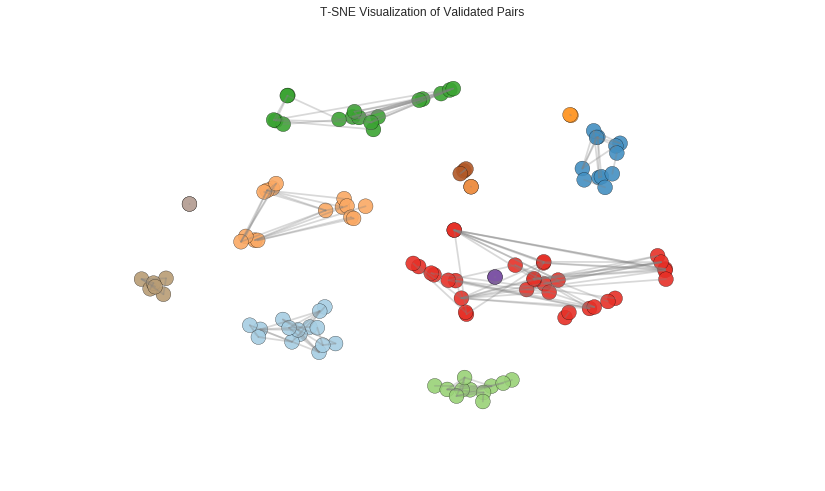

In [52]:
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=returns.T.index, data=X)
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.loc[stocks]

X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1).fit_transform(X_pairs)
#1337
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0].symbol
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]

    ticker2 = pair[0].symbol
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');
        
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=[in_pairs_series.values], cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs');